# Galactic longitude

*5 Mar 2020*

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as c

from scipy.special import iv, kv
from scipy.optimize import curve_fit

## Constants
From the Reid et al 2014 paper.

In [3]:
rsun = 8.34 # kpc
rsun_err = 0.16 # kpc

vsun = 240 # km/s
vsun_err = 8 # km/s

omegasun = vsun/rsun # km/s/kpc

## Data

Not including our calibration with W51.

In [4]:
long_list = [73.58, 64.06, 57.07, 51.20, 46.22, 41.26, 36.84, 32.65, 28.66, 24.81, 21.08, 17.44, 13.88] # deg

In [5]:
radius_list = [rsun*np.sin(np.pi/180*long) for long in long_list]
radius_err_list = [rsun_err/rsun * r for r in radius_list]

In [6]:
vpeak_list = [3.9, 26.6, 46.14, 57.5, 60.7, 77.4, 89.1, 98.7, 106.5, 107.2, 123.6, 128.9, 151.74] # km/s
v0_list = [12.7, 27.7, 52.2, 66.4, 68.9, 84.5, 95.5, 109.7, 115.4, 119.7, 127.5, 137.1, 157.07] # km/s

In [7]:
vmean_list = [0.5*(vp+v0) for (vp, v0) in zip(vpeak_list, v0_list)]
verr_list = [np.std([vp, v0], ddof=1) for vp, v0 in zip(vpeak_list, v0_list)]

TODO: calculate error correctly!!!

## Simple plot

Text(0, 0.5, 'Recessional velocity (km/s)')

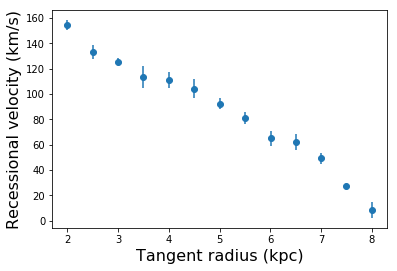

In [8]:
plt.errorbar(radius_list, vmean_list, verr_list, fmt='o')
plt.xlabel('Tangent radius (kpc)', size=16)
plt.ylabel('Recessional velocity (km/s)', size=16)

And now we make a simple plot of the rotation curve.

Text(0, 0.5, 'Rotational velocity (km/s)')

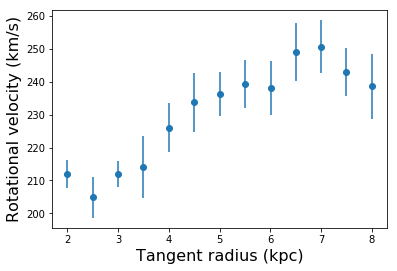

In [30]:
velocity_list = [vr+vsun*np.sin(np.pi/180*long) for vr,long in zip(vmean_list, long_list)]
velocity_err_list = [np.sqrt(verr**2 + (vsun_err*np.sin(np.pi/180*long))**2) for verr, long in zip(verr_list, long_list)]
#velocity_err_list = verr_list
plt.errorbar(radius_list, velocity_list, velocity_err_list, fmt='o')
plt.xlabel('Tangent radius (kpc)', size=16)
plt.ylabel('Rotational velocity (km/s)', size=16)

## Simple fits

In [31]:
G = c.G.to(u.km**2 * u.kpc / u.Msun / u.s**2).value
def point_fit(r, m):
    # m in Msun
    return np.sqrt(G*m/r)

popt_point, pcov_point = curve_fit(point_fit, radius_list, velocity_list)
print(popt_point)

[4.82528639e+10]


In [32]:
def uniform_fit(r, rho):
    # rho in Msun / kpc^3
    return r * np.sqrt(4/3*np.pi*G*rho)

popt_uniform, pcov_uniform = curve_fit(uniform_fit, radius_list, velocity_list)
print(popt_uniform)

[94661136.55407281]


In [33]:
def bulge_fit(r, rb, mb):
    return np.sqrt(G * abs(mb) * r) / (r+abs(rb))

In [34]:
def expdisk_fit(r, rd, sig0):
    # sig0 in Msun/kpc^2
    # rd in kpc
    # y is unitless
    y = r/rd/2
    bess = iv(0,y)*kv(0,y) - iv(1,y)*kv(1,y)
    return 4*np.pi*G*sig0*rd*y**2 * bess

popt_expdisk, pcov_expdisk = curve_fit(expdisk_fit, radius_list, velocity_list, p0=[3,1e7])
print(popt_expdisk)

[2.35686833e+00 1.02697973e+07]


In [35]:
def bulgedisk_fit(r, rb, mb, rd, sig0):
    return np.sqrt(bulge_fit(r, rb, mb)**2 + expdisk_fit(r, rd, sig0)**2)

popt_bulgedisk, pcov_bulgedisk = curve_fit(bulgedisk_fit, radius_list, velocity_list, p0=[1,1e9, 3,1e7])
print(popt_bulgedisk)

[-1.21799847e-07  1.60164163e+10  3.37118580e+00  6.35822759e+06]


(0, 400)

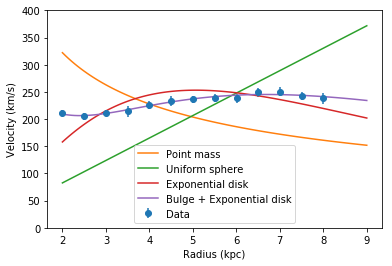

In [36]:
plt.errorbar(radius_list, velocity_list, velocity_err_list, fmt='o', label='Data')
radii = np.linspace(2,9,100)
plt.plot(radii, point_fit(radii, *popt_point), label='Point mass')
plt.plot(radii, uniform_fit(radii, *popt_uniform), label='Uniform sphere')
plt.plot(radii, expdisk_fit(radii, *popt_expdisk), label='Exponential disk')
plt.plot(radii, bulgedisk_fit(radii, *popt_bulgedisk), label='Bulge + Exponential disk')
plt.legend()
plt.xlabel('Radius (kpc)')
plt.ylabel('Velocity (km/s)')
plt.ylim(0,400)
#plt.savefig('imgs/initial_fits.png')

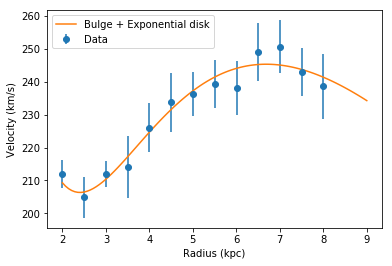

In [38]:
plt.errorbar(radius_list, velocity_list, velocity_err_list, fmt='o', label='Data')
radii = np.linspace(2,9,100)
plt.plot(radii, bulgedisk_fit(radii, *popt_bulgedisk), label='Bulge + Exponential disk')
plt.legend()
plt.xlabel('Radius (kpc)')
plt.ylabel('Velocity (km/s)')
#plt.savefig('imgs/bulgedisk_fit.png')